In [1]:
import random
import itertools

import tensorflow as tf
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import model_selection

In [2]:
def createLSTMLayers(n_layers, n_cells, dropout):
    cell_list = []
    
    for layer in range(n_layers):
        cell = tf.contrib.rnn.LayerNormBasicLSTMCell(n_cells, activation=tf.nn.relu, layer_norm=False)
        
        cell_list.append(cell)
        
    return cell_list

In [3]:
def padSeq(seqs, pad_length, right_pad=True):
    
    '''
    padSeq
    
    Pad sequences to be equal length.
    
    seqs: sequences to be padded
    pad_length: length to pad sequences
    left_pad: Pad at the end of the sequences, or reverse pad from front
    '''
    
    padded_seqs = np.zeros((len(seqs), pad_length))
    
    for idx_row, row in enumerate(seqs):
        for idx_col, col in enumerate(row):
            if right_pad:
                padded_seqs[idx_row, idx_col] = seqs[idx_row][idx_col]
            else:
                padded_seqs[idx_row, pad_length-idx_col-1] = seqs[idx_row][len(row)-idx_col-1]
    return padded_seqs

In [4]:
tf.reset_default_graph()

In [5]:
#Network parameters
encoder_layers = 1
encoder_cells = 5
encoder_dropout = 1

decoder_layers = 1
decoder_cells = 5
decoder_dropout = 1

seq_length = 5
n_features = 1

latent_dimensions = 2

#Training Parameters
lr = 0.001
batch_size = 128

In [6]:
inputs = tf.placeholder(name='input', shape=[None, seq_length, n_features], dtype=tf.float32)

In [7]:
#encoder
with tf.variable_scope('encoder', reuse=False):
    
    encoder_cell_fw = tf.contrib.rnn.MultiRNNCell(createLSTMLayers(encoder_layers, encoder_cells, encoder_dropout))
    encoder_cell_bw = tf.contrib.rnn.MultiRNNCell(createLSTMLayers(encoder_layers, encoder_cells, encoder_dropout))
    
    (encoder_fw_outputs, encoder_bw_outputs), encoder_state_outputs = tf.nn.bidirectional_dynamic_rnn(
                                        encoder_cell_fw,
                                        encoder_cell_bw, 
                                        inputs=inputs,
                                        dtype=tf.float32, time_major=False, swap_memory=True)
    
    encoder_final_state = tf.concat([state_tuple[0].h for state_tuple in encoder_state_outputs], axis=1)

In [8]:
latent_vector_in = tf.contrib.layers.fully_connected(encoder_final_state, latent_dimensions, 
                                                     activation_fn=tf.nn.relu,
                                                     normalizer_fn=tf.contrib.layers.batch_norm)

In [9]:
latent_vector_out = tf.contrib.layers.fully_connected(latent_vector_in, decoder_cells, 
                                                      activation_fn=tf.nn.relu,
                                                      normalizer_fn=tf.contrib.layers.batch_norm)

In [10]:
decoder_inputs = tf.zeros([tf.shape(inputs)[0], seq_length, n_features])

In [11]:
decoder_initial_state = tuple([tf.nn.rnn_cell.LSTMStateTuple(c=latent_vector_out, h=latent_vector_out) for i in 
                              range(decoder_layers)])

In [12]:
#decoder

with tf.variable_scope('decoder', reuse=False):
    
    decoder_cell_fw = tf.contrib.rnn.MultiRNNCell(createLSTMLayers(decoder_layers, decoder_cells, decoder_dropout))
    decoder_cell_bw = tf.contrib.rnn.MultiRNNCell(createLSTMLayers(decoder_layers, decoder_cells, decoder_dropout))
    
    (decoder_fw_outputs, decoder_bw_outputs), decoder_state_outputs = tf.nn.bidirectional_dynamic_rnn(
                                        decoder_cell_fw,
                                        decoder_cell_bw, 
                                        inputs=decoder_inputs,
                                        initial_state_fw=decoder_initial_state,
                                        initial_state_bw=decoder_initial_state,
                                        dtype=tf.float32, time_major=False, swap_memory=True)
    
    decoder_outputs = tf.concat([decoder_fw_outputs, decoder_bw_outputs], axis=2)

In [13]:
output_layer = tf.contrib.layers.fully_connected(decoder_outputs, n_features, activation_fn=tf.nn.elu)

In [14]:
loss = tf.reduce_sum(tf.square(inputs-output_layer))

In [15]:
optimizer = tf.train.AdamOptimizer(learning_rate=lr).minimize(loss)

In [35]:
def generatePseudoSequences(seq_length, low, high, n_seqs, seed, variable_length=False):
    
    '''
    generatePseudoSequences
    
    seq_length: Length of sequence to generate
    low: lower bound of values
    high: upper bound of values
    n_seqs: number of sequences to generate
    variable_length: Create sequence of variable length    
    '''
    random.seed(seed)
    
    #Generate random sequences
    random_seqs = []
    for seq in range(n_seqs):
        if variable_length: current_length = random.randint(1, seq_length)
        else: current_length = seq_length
        current_seq = [random.randint(low, high) for _ in range(current_length)]
        
        random_seqs.append(current_seq)
        
    #Generate repeating sequences    
    repeat_seqs = []
    for seq in range(n_seqs):
        if variable_length: current_length = random.randint(1, seq_length)
        else: current_length = seq_length
        seq_value = random.randint(low, high)
        current_seq = [seq_value for _ in range(current_length)]
        
        repeat_seqs.append(current_seq)
        
    #Generate ascending sequences
    
    ascend_seqs = []
    for seq in range(n_seqs):
        if variable_length: current_length = random.randint(1, seq_length)
        else: current_length = seq_length
        seq_value = random.randint(low, high)
        current_seq = [seq_value+i for i in range(0, current_length, 1)]
        
        ascend_seqs.append(current_seq)
    
    descend_seqs = []
    for seq in range(n_seqs):
        if variable_length: current_length = random.randint(1, seq_length)
        else: current_length = seq_length
        seq_value = random.randint(low+2, high)
        current_seq = [seq_value-i for i in range(0, current_length, 1)]
        
        descend_seqs.append(current_seq)
        
    return np.concatenate([descend_seqs, ascend_seqs])

In [112]:
df_seqs = pd.DataFrame(padSeq(generatePseudoSequences(5, 1, 10, 50000, 0, variable_length=True), 5))

In [113]:
seq_cols = df_seqs.columns.values

In [114]:
#df_seqs['label'] = df_seqs[seq_cols].apply(lambda x:'_'.join([str(i) for i in x]), axis=1)

In [115]:
df_seqs['label'] = df_seqs[0]>df_seqs[1]

In [116]:
df_seqs = df_seqs.sample(frac=1)

In [117]:
df_seqs.head()

,0,1,2,3,4,label
123819,6.0,7.0,8.0,9.0,0.0,False
97790,10.0,9.0,0.0,0.0,0.0,True
74535,7.0,6.0,5.0,4.0,0.0,True
99207,7.0,6.0,5.0,4.0,0.0,True
22037,3.0,2.0,1.0,0.0,0.0,True


In [118]:
df_train, df_test = model_selection.train_test_split(df_seqs, test_size=0.2)

In [119]:
df_train.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)

In [120]:
#training

n_epochs = 50

n_batches = df_train.shape[0]//batch_size

In [149]:
results[-1]

array([[[  3.45230985],
        [  4.60624647],
        [  6.60731125],
        [  8.09202099],
        [  0.        ]],

       [[  0.87339097],
        [  1.87137055],
        [  2.86317897],
        [  3.23258758],
        [  2.69249439]],

       [[  3.45230985],
        [  4.60624647],
        [  6.60731125],
        [  8.09202099],
        [  0.        ]],

       [[  6.38466692],
        [  5.55568743],
        [  4.57581186],
        [  3.79788542],
        [  2.53818345]],

       [[  2.87000394],
        [  0.        ],
        [  0.        ],
        [  0.        ],
        [  0.        ]],

       [[  3.74239182],
        [  0.        ],
        [  0.        ],
        [  0.        ],
        [  0.        ]],

       [[  8.05690479],
        [  8.10152245],
        [  8.41298103],
        [  0.        ],
        [  0.        ]],

       [[  8.09632206],
        [  7.49215317],
        [  6.81097174],
        [  6.28958082],
        [  5.57727098]],

       [[  8.12194157],


In [121]:
metrics = []
with tf.Session() as sess:
    
    sess.run(tf.global_variables_initializer())
    
    print ('Begin training')
    
    for c_epoch in range(n_epochs):
        df_epoch_samples = df_train[seq_cols].sample(frac=1)
        for c_batch in range(n_batches): 
            batch = df_epoch_samples[c_batch*batch_size:(c_batch+1)*batch_size].values
            batch = batch.reshape(len(batch), seq_length, 1)
            results = sess.run([optimizer, loss, encoder_final_state, latent_vector_in, latent_vector_out, output_layer], 
                               {inputs:batch})
            
            
            if c_batch%100==0:
                print ('epoch:%d, batch:%d, loss:%.3g' % (c_epoch, c_batch, results[1]))
                metrics.append([c_epoch, c_batch, results[1]])
    
        if epoch%10==0:
            latent_vectors = sess.run(latent_vector_in, 
                                      {inputs:df_train[seq_cols].values.reshape(df_train.shape[0], seq_length, 1)})

Begin training
epoch:0, batch:0, loss:1.79e+04
epoch:0, batch:100, loss:8.13e+03
epoch:0, batch:200, loss:3.23e+03
epoch:0, batch:300, loss:1.86e+03
epoch:0, batch:400, loss:1.31e+03
epoch:0, batch:500, loss:1.12e+03
epoch:0, batch:600, loss:923
epoch:0, batch:700, loss:918
epoch:0, batch:800, loss:760
epoch:0, batch:900, loss:1.03e+03
epoch:0, batch:1000, loss:667
epoch:0, batch:1100, loss:1.25e+03
epoch:0, batch:1200, loss:836
epoch:1, batch:0, loss:610
epoch:1, batch:100, loss:889
epoch:1, batch:200, loss:665
epoch:1, batch:300, loss:752
epoch:1, batch:400, loss:536
epoch:1, batch:500, loss:584
epoch:1, batch:600, loss:634
epoch:1, batch:700, loss:598
epoch:1, batch:800, loss:536
epoch:1, batch:900, loss:486
epoch:1, batch:1000, loss:591
epoch:1, batch:1100, loss:455
epoch:1, batch:1200, loss:493
epoch:2, batch:0, loss:485
epoch:2, batch:100, loss:587
epoch:2, batch:200, loss:580
epoch:2, batch:300, loss:416
epoch:2, batch:400, loss:532
epoch:2, batch:500, loss:448
epoch:2, batch:60

epoch:21, batch:200, loss:147
epoch:21, batch:300, loss:300
epoch:21, batch:400, loss:127
epoch:21, batch:500, loss:241
epoch:21, batch:600, loss:125
epoch:21, batch:700, loss:217
epoch:21, batch:800, loss:83.4
epoch:21, batch:900, loss:141
epoch:21, batch:1000, loss:131
epoch:21, batch:1100, loss:400
epoch:21, batch:1200, loss:151
epoch:22, batch:0, loss:191
epoch:22, batch:100, loss:249
epoch:22, batch:200, loss:151
epoch:22, batch:300, loss:129
epoch:22, batch:400, loss:159
epoch:22, batch:500, loss:215
epoch:22, batch:600, loss:207
epoch:22, batch:700, loss:118
epoch:22, batch:800, loss:85.9
epoch:22, batch:900, loss:607
epoch:22, batch:1000, loss:122
epoch:22, batch:1100, loss:102
epoch:22, batch:1200, loss:221
epoch:23, batch:0, loss:165
epoch:23, batch:100, loss:102
epoch:23, batch:200, loss:378
epoch:23, batch:300, loss:371
epoch:23, batch:400, loss:385
epoch:23, batch:500, loss:140
epoch:23, batch:600, loss:220
epoch:23, batch:700, loss:172
epoch:23, batch:800, loss:140
epoch:

epoch:42, batch:0, loss:289
epoch:42, batch:100, loss:192
epoch:42, batch:200, loss:146
epoch:42, batch:300, loss:251
epoch:42, batch:400, loss:646
epoch:42, batch:500, loss:139
epoch:42, batch:600, loss:174
epoch:42, batch:700, loss:48.9
epoch:42, batch:800, loss:300
epoch:42, batch:900, loss:334
epoch:42, batch:1000, loss:112
epoch:42, batch:1100, loss:194
epoch:42, batch:1200, loss:196
epoch:43, batch:0, loss:245
epoch:43, batch:100, loss:85.8
epoch:43, batch:200, loss:272
epoch:43, batch:300, loss:150
epoch:43, batch:400, loss:88.4
epoch:43, batch:500, loss:72.9
epoch:43, batch:600, loss:83.3
epoch:43, batch:700, loss:122
epoch:43, batch:800, loss:141
epoch:43, batch:900, loss:170
epoch:43, batch:1000, loss:88.2
epoch:43, batch:1100, loss:171
epoch:43, batch:1200, loss:286
epoch:44, batch:0, loss:115
epoch:44, batch:100, loss:128
epoch:44, batch:200, loss:105
epoch:44, batch:300, loss:110
epoch:44, batch:400, loss:98.8
epoch:44, batch:500, loss:172
epoch:44, batch:600, loss:155
epo

In [122]:
metrics = np.array(metrics)

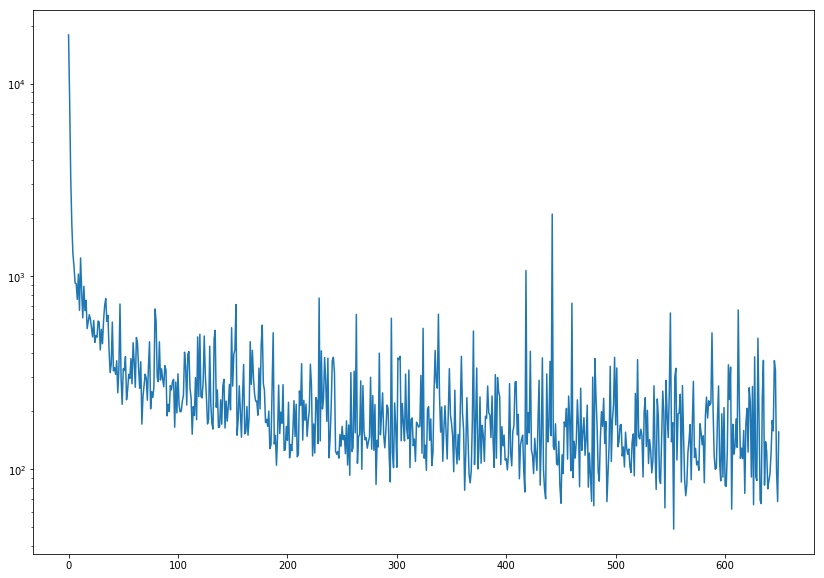

In [123]:
plt.figure(figsize=(14, 10))
plt.semilogy([i for i in range(len(metrics[:,2]))], metrics[:,2])
plt.show()

In [124]:
df_vectors = pd.DataFrame(latent_vectors, columns=['x', 'y'])

In [125]:
#Join to training data
df_seqs_vectors = df_train.merge(df_vectors, left_index=True, right_index=True)

In [133]:
df_seqs_vectors['label_add'] = df_seqs_vectors['label'].apply(str) + df_seqs_vectors[0].apply(str)

In [135]:
df_seqs_vectors['label_add'].unique()

array(['False1.0', 'True5.0', 'False10.0', 'False8.0', 'False4.0',
       'True3.0', 'False9.0', 'False7.0', 'True7.0', 'True8.0', 'False3.0',
       'True9.0', 'False2.0', 'True4.0', 'True6.0', 'True10.0', 'True2.0',
       'False6.0', 'False5.0', 'True1.0'], dtype=object)

In [134]:
df_seqs_vectors[df_seqs_vectors[0]==3].head()

,0,1,2,3,4,label,x,y,label_add
6,3.0,2.0,1.0,0.0,-1.0,True,0.725071,0.648408,True3.0
13,3.0,2.0,1.0,0.0,-1.0,True,0.725071,0.648408,True3.0
14,3.0,4.0,5.0,6.0,7.0,False,0.109554,2.459979,False3.0
18,3.0,2.0,0.0,0.0,0.0,True,0.710106,0.414639,True3.0
27,3.0,2.0,1.0,0.0,0.0,True,0.736361,0.649420,True3.0


In [143]:
label_col = 'label_add'

In [144]:
unique_seqs = df_seqs_vectors[label_col].unique()

In [145]:
palette = itertools.cycle(sns.color_palette(n_colors=len(unique_seqs)))

In [ ]:
q[0]

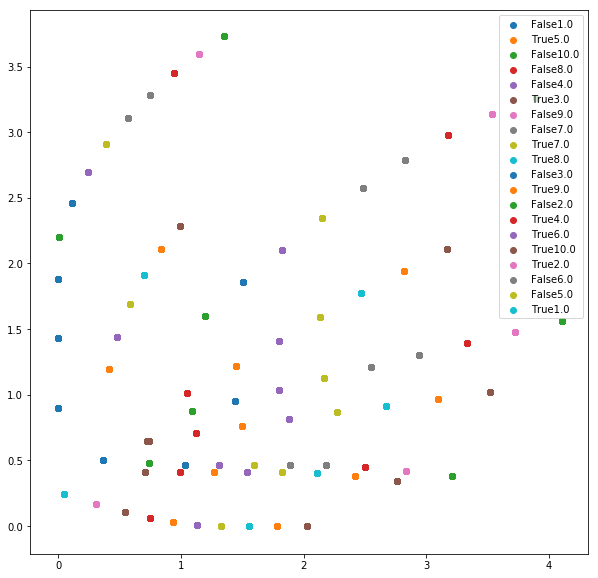

In [146]:
#Analysis

plt.figure(1, figsize=(10, 10))

for seq in unique_seqs:
    df_current = df_seqs_vectors[df_seqs_vectors[label_col]==seq]
    plt.scatter(df_current['x'].values, df_current['y'].values, color=next(palette), label=seq)

plt.legend(loc='best')
plt.show()